# Table Lookup and Interpolation of Gridding Convolution Function
In this notebook we consider the problem of evaluating the gridding convolution function using a combination of table lookup and interpolation. Unless this is done accurately, the map error can be significantly larger than when the exact function is used. We demonstrate how the error associated with table lookup and interpolation may be calculated.

As in the previous notebooks, instead of a single convolutional gridding function $C(\nu)$ with support on the interval $[-W/2,W/2]$ for integer $W$, we shall find it convenient to use the collection of $W$ functions $C_r(\nu)=C(r-\nu)$ where $\nu$ lies in the interval $[0,\frac{1}{2}]$. Given these functions and the gridding correction function $h(x)$, we calculate the map error $\ell(x)$ using
$$ \ell(x) = 2\int_0^{1/2}\mathrm{d}\nu\, \left| 1 - h(x)\displaystyle\sum_{r=-W/2+1}^{W/2}C_r(\nu)\exp[\mathrm{i}2\pi(r-\nu)x]\right|^2$$

This expression for the map error is valid for any combination of convolution and correction functions. In particular, we may discover the effects of table lookup and interpolation by replacing the accurate values of $C_r(\nu)$ by the approximate values obtained via the interpolation procedure. The gridding correction function $h(x)$ is the same whether or not the $C_r$ are interpolated.

The lookup table for $C_r$ involves evaluating it on some uniformly spaced set of points in the interval $[0,\frac{1}{2}]$. We denote the separation between the tabulated points by $1/M_s$ for some even integer $M_s$ and define $\nu_k=k/M_s$. Newton's forward difference formula of degree $d$ for computing the value of $C_r(\nu)$ for some $\nu_k\leq\nu\leq\nu_{k+1}$ effectively finds the polynomial of degree $d$ that passes through the points $C_r(\nu_k)$, $C_r(\nu_{k+1}),...,C_r(\nu_{k+d})$ and evaluates that polynomial at $\nu$. As described in Abramowitz and Stegun 25.2.28, it does this by computing finite differences up to order $d$ of the function values.

The functions `make_lookup_table` and `get_grid_weights` in the file `algorithms/core.py` calculate the table of finite differences and use them to evaluate convolution gridding functions using the Newton interpolation formula. The desired degree of interpolation is specified when making the lookup table. If the degree is set to zero, nearest-neighbor lookup into the table is performed instead of using the left-hand neighbor as this gives improved accuracy.

When calculating the map error $\ell(x)$, the integral over $\nu$ is approximated by a mean over the samples of the integrand. When we wish to evaluate the effects of interpolating into a lookup table, it is important that these samples do not happen to coincide exactly with the points at which the lookup table is evaluated, since the values of the function are accurate there, resulting in an incorrectly small value for the error. Instead, we sample the integrand at a set of points distributed uniformly at random within the interval of integration.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys

from algorithms.core import (make_lookup_table, get_grid_weights, OptFunc, 
                             Lookup, calc_C, calc_map_error_from_C, 
                             C_to_grid_correction)

# Evaluating the map error for various degrees of interpolation
In the next cell we load the results of the optimization for the least-misfit gridding functions from the pickle file computed in the notebook entitled "Optimization to find least misfit functions". We shall investigate how the map error is affected by using a lookup table when different degrees of interpolation are used. For definiteness, we consider using $M_s=32$ which effectively samples the convolution function at intervals of $1/32$ and uses polynomial interpolation between these samples.

In [2]:
import pickle
with open("min_misfit_gridding_14.pkl", "rb") as pp:
    opt_funcs = pickle.load(pp)
    
opt = opt_funcs[7]  # Select optimal function for W=7

<IPython.core.display.Javascript object>


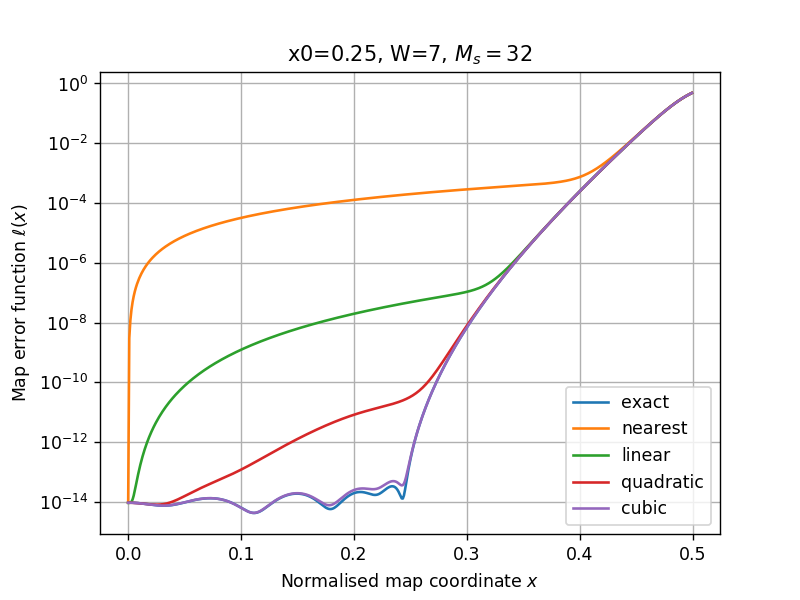

Text(0.5, 1.0, 'x0=0.25, W=7, $M_s=32$')

In [3]:
M = 128
nu_C = (np.arange(M) + 0.5)/(2*M)
N = 512
x = np.arange(N)/(2*N)

plt.figure()

# Calculate result for no interpolation ("exact" C)
C = calc_C(opt.h, opt.x0, nu_C, opt.W)
correction = C_to_grid_correction(C, nu_C, x, optimal=True)
ell = calc_map_error_from_C(C, correction, nu_C, x, opt.W)
plt.semilogy(x, ell, label='exact')

Ms = 32
nu_R = np.random.uniform(0, 0.5, 2048)  # Random positions for evaluating map error
for degree in range(4):  # Use interpolation degrees 0, 1, 2 and 3
    lookup = make_lookup_table(opt, Ms=Ms, degree=degree)
    # Get the convolution functions at the points in nu_R using
    #  table look up and interpolation via get_grid_weights
    C = np.zeros((opt.W, len(nu_R)))
    for i, nu in enumerate(nu_R):
        _, C[:,i] = get_grid_weights(lookup, nu + 0.5 * (opt.W % 2))
    ell = calc_map_error_from_C(C, correction, nu_R, x, opt.W)
    plt.semilogy(x, ell, label=['nearest','linear','quadratic','cubic'][degree])
    
plt.xlabel('Normalised map coordinate $x$')
plt.ylabel('Map error function $\\ell(x)$')
plt.grid(True)
plt.legend()
plt.title("x0=%g, W=%g, $M_s=%g$" % (opt.x0, opt.W, Ms))

It is apparent that as the degree of the interpolation increases, the map error becomes closer to that using the exact convolution function. It is also of interest to see how the error functions approach that for the exact convolution function as the size of the lookup table (as determined by $M_s$) increases.

<IPython.core.display.Javascript object>


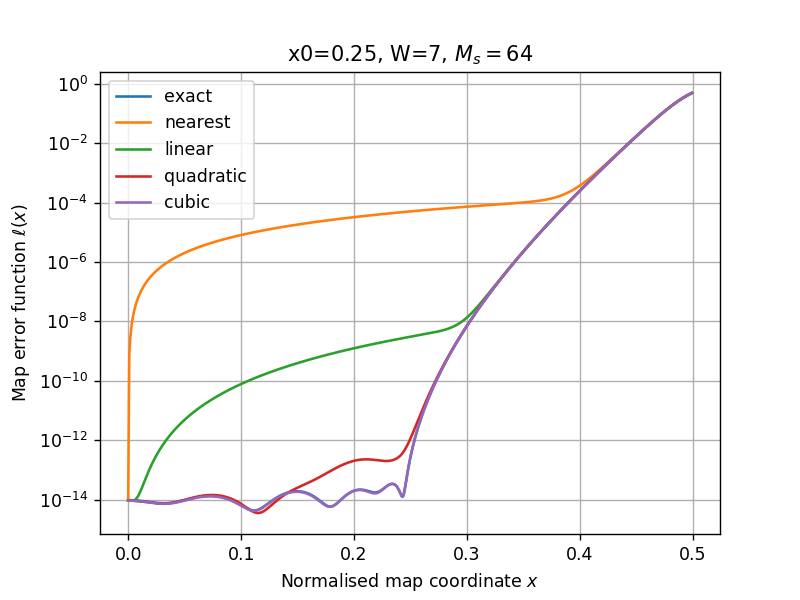

<IPython.core.display.Javascript object>


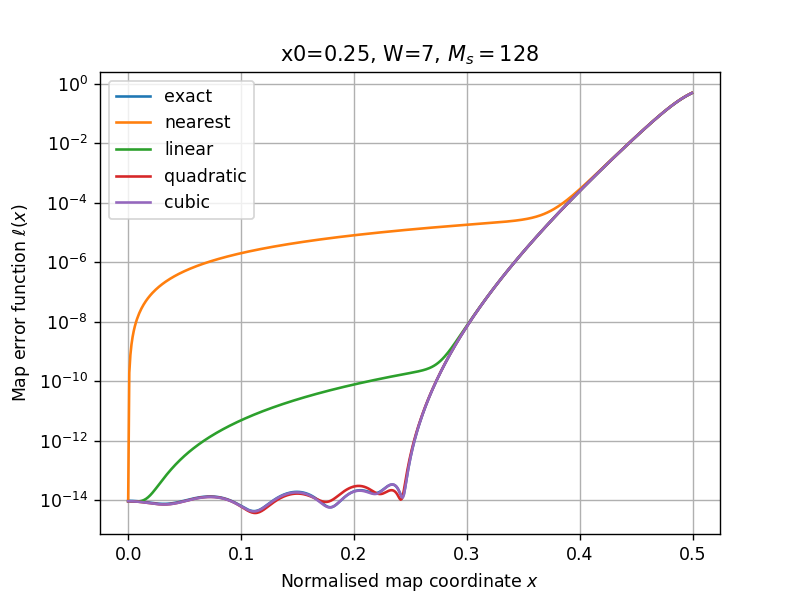

<IPython.core.display.Javascript object>


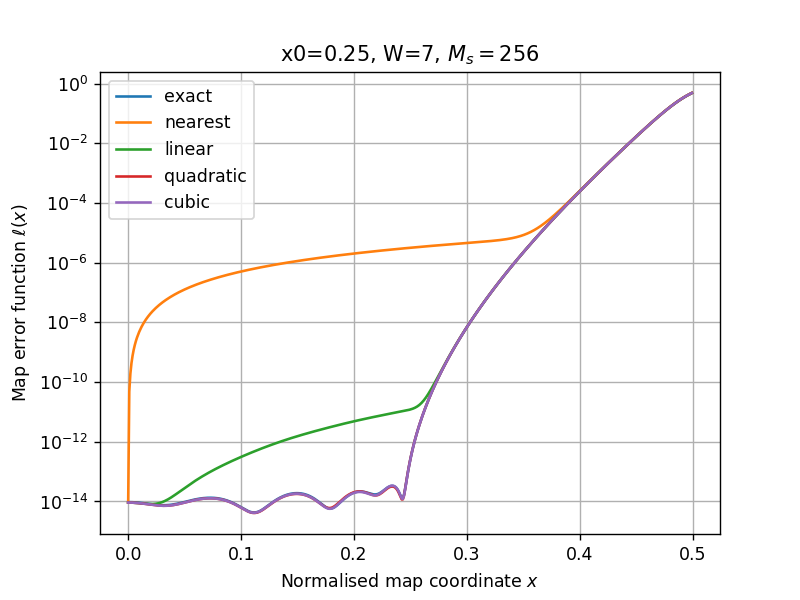

<IPython.core.display.Javascript object>


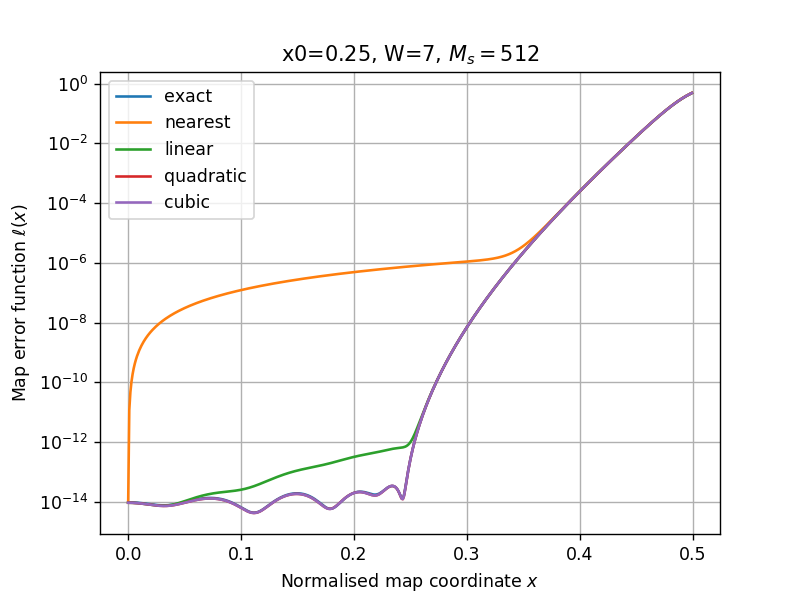

In [4]:
M = 128
nu_C = (np.arange(M) + 0.5)/(2*M)
N = 512
x = np.arange(N)/(2*N)

# Calculate result for no interpolation ("exact" C)
C = calc_C(opt.h, opt.x0, nu_C, opt.W)
correction = C_to_grid_correction(C, nu_C, x, optimal=True)
ell_0 = calc_map_error_from_C(C, correction, nu_C, x, opt.W)

nu_R = np.random.uniform(0, 0.5, 2048)  # Random positions for evaluating map error

Ms_list = [64, 128, 256, 512]
for Ms in Ms_list:
    plt.figure()
    plt.semilogy(x, ell_0, label='exact')
    for degree in range(4):  # Use interpolation degrees 0, 1, 2 and 3
        lookup = make_lookup_table(opt, Ms=Ms, degree=degree)
        # Get the convolution functions at the points in nu_R using
        #  table look up and interpolation via get_grid_weights
        C = np.zeros((opt.W, len(nu_R)))
        for i, nu in enumerate(nu_R):
            _, C[:,i] = get_grid_weights(lookup, nu + 0.5 * (opt.W % 2))
        ell = calc_map_error_from_C(C, correction, nu_R, x, opt.W)
        plt.semilogy(x, ell, label=['nearest','linear','quadratic','cubic'][degree])
    
    plt.xlabel('Normalised map coordinate $x$')
    plt.ylabel('Map error function $\\ell(x)$')
    plt.grid(True)
    plt.legend()
    plt.title("x0=%g, W=%g, $M_s=%g$" % (opt.x0, opt.W, Ms))

By calculating the RMS error $\sqrt{E}$ over the portion of map retained, where
$$E=\frac{1}{x_0}\int_0^{x_0} \ell(x)\,\mathrm{d}x$$
we can see how this varies with $M_s$ for the different degrees of interpolation. This allows an estimate of the size of the lookup table needed to make the effects of lookup and interpolation negligible.

<IPython.core.display.Javascript object>


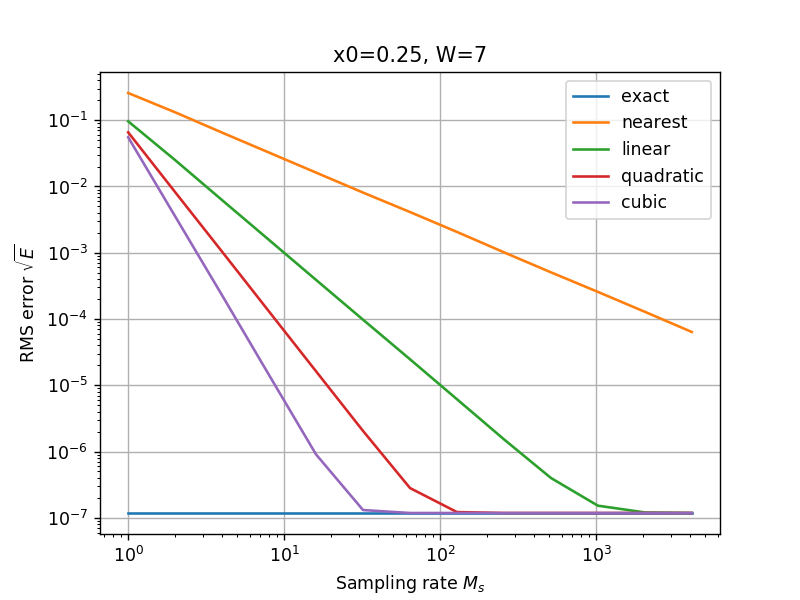

In [5]:
M = 128
nu_C = (np.arange(M) + 0.5)/(2*M)
N = 512
x = np.arange(N)/(2*N)
edge = np.flatnonzero(x >= opt.x0)

# Calculate result for no interpolation ("exact" C)
C = calc_C(opt.h, opt.x0, nu_C, opt.W)
correction = C_to_grid_correction(C, nu_C, x, optimal=True)
ell = calc_map_error_from_C(C, correction, nu_C, x, opt.W)
rms_err_exact = np.sqrt(np.mean(ell[:edge[0]]))

nu_R = np.random.uniform(0, 0.5, 2048)  # Random positions for evaluating map error

Ms_list = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]
rms_err = np.zeros((len(Ms_list), 4))
for j, Ms in enumerate(Ms_list):
    for degree in range(4):  # Use interpolation degrees 0, 1, 2 and 3
        lookup = make_lookup_table(opt, Ms=Ms, degree=degree)
        # Get the convolution functions at the points in nu_R using
        #  table look up and interpolation via get_grid_weights
        C = np.zeros((opt.W, len(nu_R)))
        for i, nu in enumerate(nu_R):
            _, C[:,i] = get_grid_weights(lookup, nu + 0.5 * (opt.W % 2))
        ell = calc_map_error_from_C(C, correction, nu_R, x, opt.W)
        rms_err[j, degree] = np.sqrt(np.mean(ell[:edge[0]]))

plt.figure()
plt.loglog(Ms_list, rms_err_exact*np.ones_like(Ms_list), label='exact')
for degree in range(4):
    plt.loglog(Ms_list, rms_err[:, degree], label=['nearest','linear','quadratic','cubic'][degree])
plt.xlabel("Sampling rate $M_s$")
plt.ylabel("RMS error $\sqrt{E}$")
plt.title("x0=%g, W=%g" % (opt.x0, opt.W))
plt.grid(True)
plt.legend()      